In [43]:
import imp
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import h5py

import util
from plot_core import PlotAx, STYLE_PATH
from util import *
from data_loader import LoadRealCris
from plot_model_training import *
from spectrum_conversion import iasi2hiras

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

In [44]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers

In [45]:
style_file = os.path.join(STYLE_PATH, 'plot_regression.mplstyle')
plt.style.use(style_file)

In [46]:
in_dir = '/home/cali/data/GapFilling/FY4A+GIIRS_NPP+CRIS/201902'
in_dir2 = '/home/cali/data/GapFilling/FY4A+GIIRS_NPP+CRIS/201902'
pic_dir = 'Picture'
result_dir = 'Result'
data_dir = 'Data'
model_dir = 'Model'
for _dir in [pic_dir, result_dir, data_dir, model_dir]:
    if not os.path.isdir(_dir):
        os.makedirs(_dir)
    print(_dir)

Picture
Result
Data
Model


# 合成全部的Real CRIS数据

In [47]:
class LoadGiirsCris(object):
    """
    读取GIIRS和CRIS的匹配数据
    """
    def __init__(self, in_file):
        self.in_file = in_file
        self.wn_giirs = [(700., 1130., 0.625), (1650., 2250., 0.625),]
        self.wn_cris = [(650., 1095., 0.625), ] 
    
    def get_giirs_radiance(self):
        with h5py.File(self.in_file) as hdf5:
            rad = hdf5.get('GEO_Spectrum_rad')[:].T
        return rad
#     def get_giirs_radiance(self):
#         with h5py.File(self.in_file) as hdf5:
#             rad = hdf5.get('GEO_Spectrum_rad')[:].T
#             rad = pd.DataFrame(rad)
#         wavenumber = self.get_giirs_wavenumber()

#         real_lw = get_data_by_wavenumber_range(rad, wavenumber, self.wn_giirs[0:1])
#         real_mw = get_data_by_wavenumber_range(rad, wavenumber, self.wn_giirs[1:2])
        
#         real_lw = np.array(real_lw)
#         real_mw = np.array(real_mw)
        
#         w0 = 0.23
#         w1 = 0.54
#         w2 = 0.23
#         real_lw[:, 1:-1] = w0 * real_lw[:, :-2] + w1 * real_lw[:, 1:-1] + w2 * real_lw[:, 2:]
#         real_mw[:, 1:-1] = w0 * real_mw[:, :-2] + w1 * real_mw[:, 1:-1] + w2 * real_mw[:, 2:]
#         response = np.concatenate((real_lw, real_mw), axis=1)
#         return response

    def get_cris_radiance(self):
        with h5py.File(self.in_file) as hdf5:
            rad = hdf5.get('LEO_Spectrum_rad')[0:713].T
#         w0 = 0.23
#         w1 = 0.54
#         w2 = 0.23
#         rad[:, 1:-1] = w0 * rad[:, :-2] + w1 * rad[:, 1:-1] + w2 * rad[:, 2:]
        return rad
    
    def get_giirs_wavenumber(self):
        return get_wavenumber_by_range(self.wn_giirs)

    def get_cris_wavenumber(self):
        return get_wavenumber_by_range(self.wn_cris)
        

In [48]:
def load_all_matched_data_giirs_cris(in_files):
    response_all_giirs = None
    wavenumber_giirs = None
    for in_file in in_files:
        response_giirs = LoadGiirsCris(in_file).get_giirs_radiance()
        if response_all_giirs is None:
            response_all_giirs = response_giirs
        else:
            response_all_giirs = np.concatenate((response_all_giirs, response_giirs), axis=0)
        if wavenumber_giirs is None:
            wavenumber_giirs = LoadGiirsCris(in_file).get_giirs_wavenumber()
    
    response_all_cris = None
    wavenumber_cris = None
    for in_file in in_files:
        response_cris = LoadGiirsCris(in_file).get_cris_radiance()
        if response_all_cris is None:
            response_all_cris = response_cris
        else:
            response_all_cris = np.concatenate((response_all_cris, response_cris), axis=0)
        if wavenumber_cris is None:
            wavenumber_cris = LoadGiirsCris(in_file).get_cris_wavenumber()
    
    return pd.DataFrame(response_all_giirs), pd.DataFrame(response_all_cris), wavenumber_giirs, wavenumber_cris

In [49]:
class LoadGiirsIasi(object):
    """
    读取GIIRS和IASI的匹配数据
    """
    def __init__(self, in_file):
        self.in_file = in_file
        self.wn_giirs = [(700., 1130., 0.625), (1650., 2250., 0.625),]
        self.wn_iasi = [(645.25, 2760.25, 0.25), ] 
        
    def get_giirs_radiance(self):
        with h5py.File(self.in_file) as hdf5:
            rad = hdf5.get('GEO_Spectrum_rad')[:].T
        wavenumber = self.get_giirs_wavenumber()
    
        real_lw = get_data_by_wavenumber_range(rad, wavenumber, self.wn_giirs[0:1])
        real_mw = get_data_by_wavenumber_range(rad, wavenumber, self.wn_giirs[1:2])
        
        real_lw = np.array(real_lw)
        real_mw = np.array(real_mw)
        
        w0 = 0.23
        w1 = 0.54
        w2 = 0.23
        real_lw[:, 1:-1] = w0 * real_lw[:, :-2] + w1 * real_lw[:, 1:-1] + w2 * real_lw[:, 2:]
        real_mw[:, 1:-1] = w0 * real_mw[:, :-2] + w1 * real_mw[:, 1:-1] + w2 * real_mw[:, 2:]
        response = np.concatenate((real_lw, real_mw), axis=1)
        return response

    def get_iasi_radiance(self):
        with h5py.File(self.in_file) as hdf5:
            rad = hdf5.get('LEO_Spectrum_rad')[:].T
        return rad
    
    def get_giirs_wavenumber(self):
        return get_wavenumber_by_range(self.wn_giirs)

    def get_iasi_wavenumber(self):
        return get_wavenumber_by_range(self.wn_cris)

In [50]:
def load_all_matched_data_giirs_iasi(in_files):
    response_all_giirs = None
    wavenumber_giirs = None
    for in_file in in_files:
        response_giirs = LoadGiirsCris(in_file).get_giirs_radiance()
        if response_all_giirs is None:
            response_all_giirs = response_giirs
        else:
            response_all_giirs = np.concatenate((response_all_giirs, response_giirs), axis=0)
        if wavenumber_giirs is None:
            wavenumber_giirs = LoadGiirsCris(in_file).get_giirs_wavenumber()
    
    response_all_cris = None
    wavenumber_cris = None
    for in_file in in_files:
        response_cris = LoadGiirsCris(in_file).get_cris_radiance()
        if response_all_cris is None:
            response_all_cris = response_cris
        else:
            response_all_cris = np.concatenate((response_all_cris, response_cris), axis=0)
        if wavenumber_cris is None:
            wavenumber_cris = LoadGiirsCris(in_file).get_cris_wavenumber()
    
    return pd.DataFrame(response_all_giirs), pd.DataFrame(response_all_cris), wavenumber_giirs, wavenumber_cris

# 加载全部波段数据

In [51]:
real_files = [os.path.join(in_dir, i) for i in os.listdir(in_dir)]

In [52]:
data_all_x, data_all_y, wavenumber_x, wavenumber_y = load_all_matched_data_giirs_cris(real_files)

In [53]:
print(data_all_x.shape)
print(data_all_y.shape)

(1493, 1650)
(1493, 713)


In [54]:
def get_data_by_wavenumber_range(df_data, wavenumber, ranges):
    """
    根据波数和波数范围获取数据
    :param df_data: pd.DataFrame 格式
    :param wavenumber: 波数
    :param ranges: 波段范围和分辨率 [(start, end, frequency),]
    :return:
    """
    if not isinstance(df_data, pd.DataFrame):
        df_data = pd.DataFrame(df_data)

    wavenumber = wavenumber.tolist()
    idx = list()
    for range_s, range_e, _ in ranges:
        idx_s = wavenumber.index(range_s)
        idx_e = wavenumber.index(range_e)
        idx_tmp = [i for i in range(idx_s, idx_e+1)]
        if idx is None:
            idx = idx_tmp
        else:
            idx.extend(idx_tmp)

    return df_data.loc[:, idx]

In [55]:
data_all_x_part = get_data_by_wavenumber_range(data_all_x, wavenumber_x, [(700., 1095., 0.625),])
wavenumber_x_part = get_wavenumber_by_range([(700., 1095., 0.625),])

In [56]:
data_all_y_part = get_data_by_wavenumber_range(data_all_y, wavenumber_y, [(700., 1095., 0.625),])
wavenumber_y_part = get_wavenumber_by_range([(700., 1095., 0.625),])

In [57]:
print(type(data_all_x_part))
print(data_all_x_part.shape)

print(type(data_all_y_part))
print(data_all_y_part.shape)

# 判断是否有小于0和等于nan的无效值
print(np.where(data_all_x_part<=0)[0].shape)
print(np.where(np.isnan(data_all_x_part))[0].shape)

# 判断是否有小于0和等于nan的无效值
print(np.where(data_all_y_part<=0)[0].shape)
print(np.where(np.isnan(data_all_y_part))[0].shape)

<class 'pandas.core.frame.DataFrame'>
(1493, 633)
<class 'pandas.core.frame.DataFrame'>
(1493, 633)
(0,)
(0,)
(0,)
(0,)


In [58]:
tbb_all_x_part = np.array(rad2tbb(data_all_x_part, wavenumber_x_part))
tbb_all_y_part = np.array(rad2tbb(data_all_y_part, wavenumber_y_part))

result = tbb_all_x_part - tbb_all_y_part
result_mean1 = np.nanmean(result, axis=0)

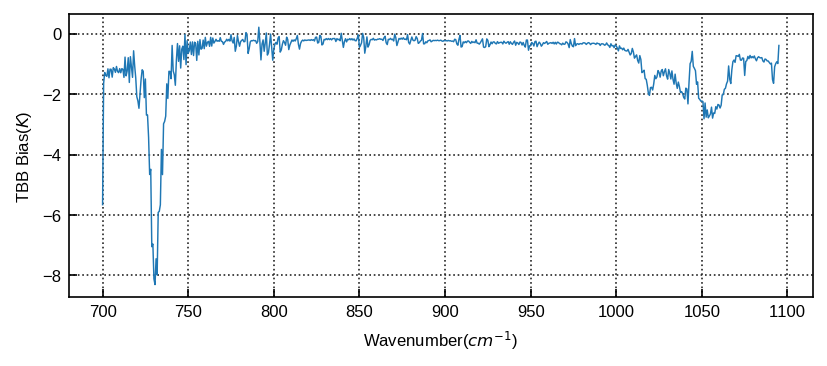

In [59]:
figsize2 = (6.4, 2.5)
fig = plt.figure(figsize=figsize2, dpi=150)
plt.plot(wavenumber_x_part, result_mean1, lw=0.7)
plt.xlabel('Wavenumber($cm^{-1}$)')
plt.ylabel('TBB Bias($K$)')
plt.show()

# 预测通道与CRIS的对比

In [60]:
X_data = get_data_by_wavenumber_range(data_all_x, wavenumber_x, [(760., 1050., 0.625), (1800., 2188.125, 0.625),])

In [61]:
model_name = 'test_giirs'
linear_model_attribute_file_business = os.path.join(model_dir, 'linear_model_attribute_{}.h5'.format(model_name))
coef, intercept = get_linear_model_attributes(linear_model_attribute_file_business)

In [62]:
Y_predict = X_data.dot(coef) + intercept

In [63]:
Y_predict.shape
print(type(Y_predict))

<class 'pandas.core.frame.DataFrame'>


In [64]:
ranges_Y_all = [(650, 699.375, 0.625), (700, 759.375, 0.625), (1050.625, 1130, 0.625),
                (1130., 1649.375, 0.625), (1650., 1799.375, 0.625), (2188.75, 2250., 0.625),
               (2250.625, 2755., 0.625),]

In [65]:
wavenumber_y_predict = get_wavenumber_by_range(ranges_Y_all)

In [66]:
data_x_part1 = get_data_by_wavenumber_range(Y_predict, wavenumber_y_predict, [(700, 759.375, 0.625),])

In [67]:
data_x_part2 = get_data_by_wavenumber_range(data_all_x, wavenumber_x, [(760., 1050., 0.625),])

In [68]:
data_x_part3 = get_data_by_wavenumber_range(Y_predict, wavenumber_y_predict, [(1050.625, 1095, 0.625),])

In [69]:
data_x_part_new = np.concatenate((data_x_part1, data_x_part2, data_x_part3), axis=1)

In [70]:
print(data_x_part_new.shape)

(1493, 633)


/home/cali/src/gap_filling/util.py:77: RuntimeWarning: invalid value encountered in log
  tbb = (c2 * center_wave) / np.log(1 + ((c1 * center_wave ** 3) / radiance))


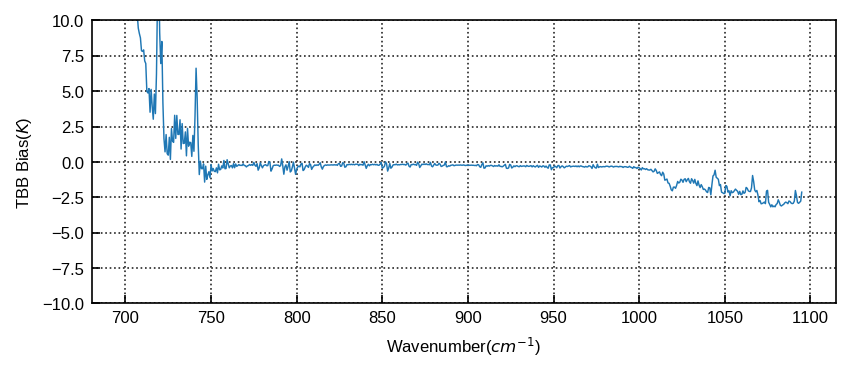

In [71]:
tbb_x_part = np.array(rad2tbb(data_x_part_new, wavenumber_x_part))
tbb_y_part = np.array(rad2tbb(data_all_y_part, wavenumber_y_part))

result = tbb_x_part - tbb_y_part
result_mean2 = np.nanmean(result, axis=0)

figsize2 = (6.4, 2.5)
fig = plt.figure(figsize=figsize2, dpi=150)
plt.plot(wavenumber_x_part, result_mean2, lw=0.7)
plt.ylim(-10, 10)
plt.xlabel('Wavenumber($cm^{-1}$)')
plt.ylabel('TBB Bias($K$)')
plt.show()


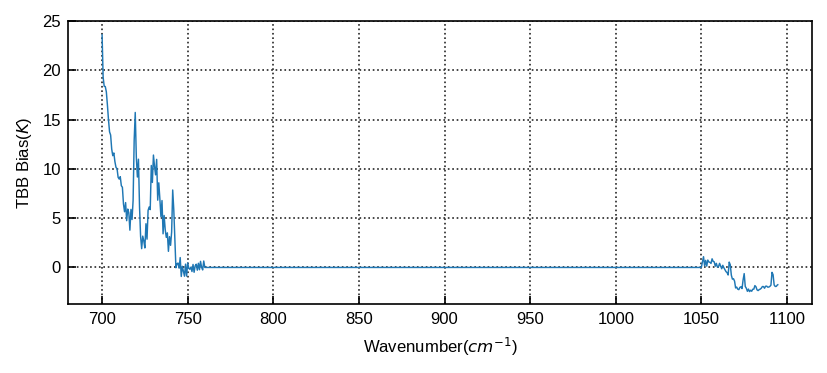

In [72]:
figsize2 = (6.4, 2.5)
fig = plt.figure(figsize=figsize2, dpi=150)
plt.plot(wavenumber_x_part, result_mean2 - result_mean1, lw=0.7)
plt.xlabel('Wavenumber($cm^{-1}$)')
plt.ylabel('TBB Bias($K$)')
plt.show()

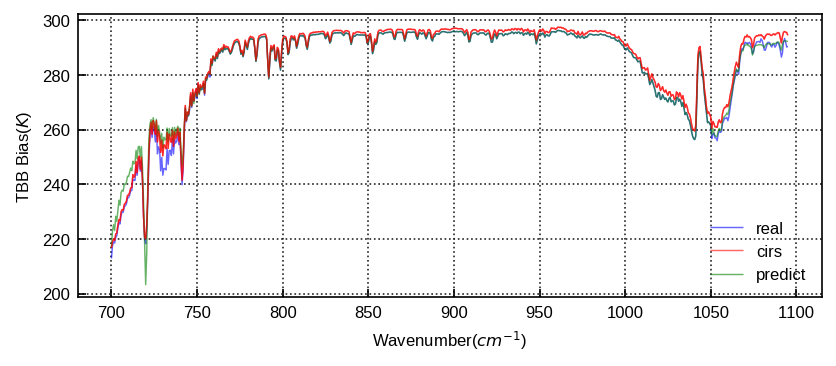

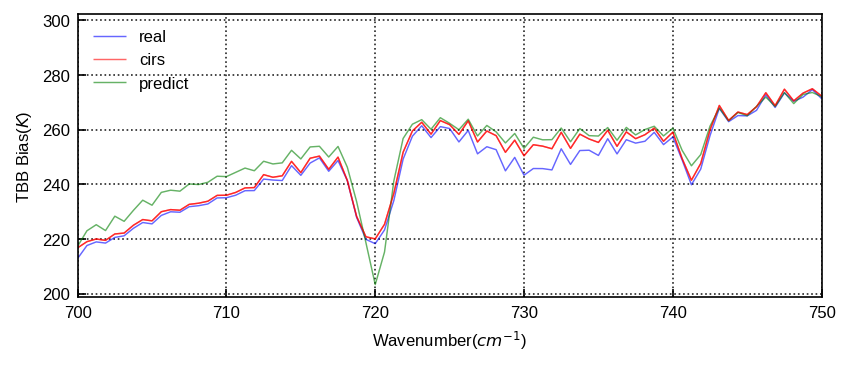

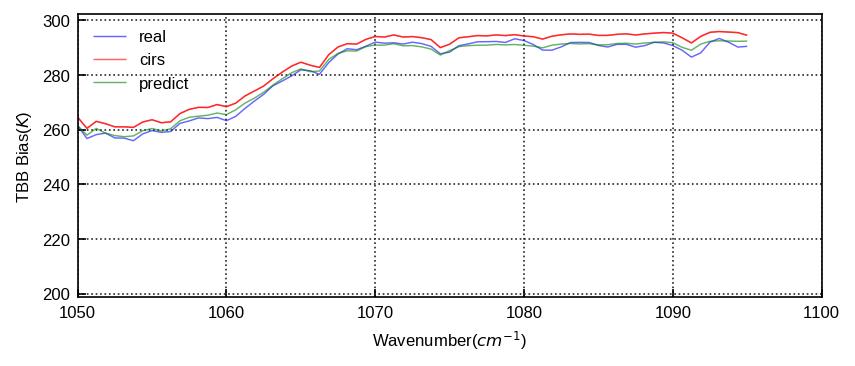

In [73]:
data_number = 1
figsize2 = (6.4, 2.5)
fig = plt.figure(figsize=figsize2, dpi=150)
plt.plot(wavenumber_x_part, tbb_all_x_part[data_number], lw=0.7, c='b', alpha=0.6, label='real')
plt.plot(wavenumber_x_part, tbb_all_y_part[data_number], lw=0.7, c='r', alpha=0.6, label='cirs')
plt.plot(wavenumber_x_part, tbb_x_part[data_number], lw=0.7, c='g', alpha=0.6, label='predict')
plt.plot(wavenumber_x_part, tbb_y_part[data_number], lw=0.7, c='r', alpha=0.6)
plt.legend()
plt.xlabel('Wavenumber($cm^{-1}$)')
plt.ylabel('TBB Bias($K$)')
plt.show()

data_number = 1
figsize2 = (6.4, 2.5)
fig = plt.figure(figsize=figsize2, dpi=150)
plt.plot(wavenumber_x_part, tbb_all_x_part[data_number], lw=0.7, c='b', alpha=0.6, label='real')
plt.plot(wavenumber_x_part, tbb_all_y_part[data_number], lw=0.7, c='r', alpha=0.6, label='cirs')
plt.plot(wavenumber_x_part, tbb_x_part[data_number], lw=0.7, c='g', alpha=0.6, label='predict')
plt.plot(wavenumber_x_part, tbb_y_part[data_number], lw=0.7, c='r', alpha=0.6)
plt.legend()
plt.xlim(700, 750)
plt.xlabel('Wavenumber($cm^{-1}$)')
plt.ylabel('TBB Bias($K$)')
plt.show()

data_number = 1
figsize2 = (6.4, 2.5)
fig = plt.figure(figsize=figsize2, dpi=150)
plt.plot(wavenumber_x_part, tbb_all_x_part[data_number], lw=0.7, c='b', alpha=0.6, label='real')
plt.plot(wavenumber_x_part, tbb_all_y_part[data_number], lw=0.7, c='r', alpha=0.6, label='cirs')
plt.plot(wavenumber_x_part, tbb_x_part[data_number], lw=0.7, c='g', alpha=0.6, label='predict')
plt.plot(wavenumber_x_part, tbb_y_part[data_number], lw=0.7, c='r', alpha=0.6)
plt.legend()
plt.xlim(1050, 1100)
plt.xlabel('Wavenumber($cm^{-1}$)')
plt.ylabel('TBB Bias($K$)')
plt.show()

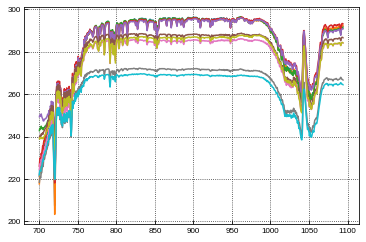

In [36]:
for i in range(0, 10):
    plt.plot(wavenumber_x_part, tbb_x_part[i])
plt.show()

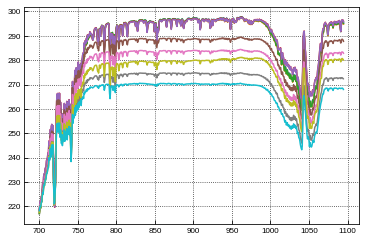

In [37]:
for i in range(0, 10):
    plt.plot(wavenumber_x_part, tbb_y_part[i])
plt.show()

In [38]:
iband = 1
spec_iasi2giirs, wavenumber_iasi2giirs, plot_data_iasi2giirs = iasi2hiras(
            radiance, IASI_BAND_F1[iband], IASI_BAND_F2[iband], IASI_D_FREQUENCY[iband],
            GIIRS_BAND_F1[iband], GIIRS_BAND_F2[iband], GIIRS_D_FREQUENCY[iband],
            GIIRS_F_NYQUIST, GIIRS_RESAMPLE_MAXX[iband], GIIRS_FILTER_WIDTH[iband],
            apodization_ori=iasi_apod, )

NameError: name 'radiance' is not defined

In [39]:
out_filename_business = '0000_' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '_{}.png'.format(model_name)
out_file_business = os.path.join(validate_dir, out_filename_business)
plot_model_validate(predict_Y_tbb_business, predict_Y_tbb_test, wavenumber_Y, index_Y, out_file_business)

NameError: name 'ranges_X' is not defined

In [40]:
validate_dir = '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '_validate'
validate_dir = os.path.join(result_dir, validate_dir)
if not os.path.isdir(validate_dir):
    os.mkdir(validate_dir)
print(validate_dir)

file_name = os.path.join(validate_dir, 's_{:04d}_{:02d}_{}.png')

alpha = 0.7
figsize1 = (6.4, 2.5)
figsize2 = (6.4, 1.5)

lw = 1

for data_number in range(0, 1):
    count = 0
    fig = plt.figure(figsize=figsize1, dpi=150)

    plt.plot(wavenumber, data_all.iloc[data_number], 'b-', alpha=alpha, label='real', lw=1)

    plt.plot(wavenumber_Y, Y_predict.iloc[data_number], 'g-', alpha=alpha, label='predict', lw=1)

    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB ($K$)')
    plt.legend()
    plt.show()
    fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
    fig.clear()
    plt.close()
    print(file_name.format(data_number, count, model_name))
    count += 1
    
    fig = plt.figure(figsize=figsize1, dpi=150)

    plt.plot(wavenumber[0:96], data_all.iloc[data_number, 0:96], 'b-', alpha=alpha, label='real', lw=1)
    plt.plot(wavenumber[0:96], Y_predict.iloc[data_number, 80:176], 'g-', alpha=alpha, label='predict', lw=1)

    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB ($K$)')
    plt.legend()
    plt.show()
    fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
    fig.clear()
    plt.close()
    print(file_name.format(data_number, count, model_name))
    count += 1
    
    fig = plt.figure(figsize=figsize1, dpi=150)

    plt.plot(wavenumber[561:689], data_all.iloc[data_number, 561:689], 'b-', alpha=alpha, label='real', lw=1)
    plt.plot(wavenumber[561:689], Y_predict.iloc[data_number, 176:304], 'g-', alpha=alpha, label='predict', lw=1)

    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB ($K$)')
    plt.legend()
    plt.show()
    fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
    fig.clear()
    plt.close()
    print(file_name.format(data_number, count, model_name))
    count += 1
    
    fig = plt.figure(figsize=figsize1, dpi=150)

    plt.plot(wavenumber[689:929], data_all.iloc[data_number, 689:929], 'b-', alpha=alpha, label='real', lw=1)
    plt.plot(wavenumber[689:929], Y_predict.iloc[data_number, 1136:1376], 'g-', alpha=alpha, label='predict', lw=1)

    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB ($K$)')
    plt.legend()
    plt.show()
    fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
    fig.clear()
    plt.close()
    print(file_name.format(data_number, count, model_name))
    count += 1
    
    fig = plt.figure(figsize=figsize1, dpi=150)

    plt.plot(wavenumber[1551:1649], data_all.iloc[data_number, 1551:1649], 'b-', alpha=alpha, label='real', lw=1)

    plt.plot(wavenumber[1551:1649], Y_predict.iloc[data_number,1376:1474], 'g-', alpha=alpha, label='predict', lw=1)

    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB ($K$)')
    plt.legend()
    plt.show()
    fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
    fig.clear()
    plt.close()
    print(file_name.format(data_number, count, model_name))
    count += 1
    
    fig = plt.figure(figsize=figsize1, dpi=150)
    w = wavenumber[0:96]
    bias = np.array(Y_predict.iloc[data_number, 80:176]) - np.array(data_all.iloc[data_number, 0:96])
    plt.plot(w, bias, 'r-', alpha=alpha, lw=1)

    w = wavenumber[561:689]
    bias = np.array(Y_predict.iloc[data_number, 176:304]) - np.array(data_all.iloc[data_number, 561:689])
    plt.plot(w, bias, 'r-', alpha=alpha, lw=1)
    
    w = wavenumber[689:929]
    bias = np.array(Y_predict.iloc[data_number, 1136:1376]) - np.array(data_all.iloc[data_number, 689:929])
    plt.plot(w, bias, 'r-', alpha=alpha, lw=1)
    
    w = wavenumber[1551:1649]
    bias = np.array(Y_predict.iloc[data_number, 1376:1474]) - np.array(data_all.iloc[data_number, 1551:1649])
    plt.plot(w, bias, 'r-', alpha=alpha, lw=1)
    
    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB Bias($K$)')
    plt.show()
    fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
    fig.clear()
    plt.close()
    print(file_name.format(data_number, count, model_name))
    count += 1
    
    fig = plt.figure(figsize=figsize1, dpi=150)
    w = wavenumber[0:96]
    bias = np.array(Y_predict.iloc[data_number, 80:176]) - np.array(data_all.iloc[data_number, 0:96])
    plt.plot(w, bias, 'r-', alpha=alpha, lw=1)
    
    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB Bias($K$)')
    plt.show()
    fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
    fig.clear()
    plt.close()
    print(file_name.format(data_number, count, model_name))
    count += 1

    fig = plt.figure(figsize=figsize1, dpi=150)
    w = wavenumber[561:689]
    bias = np.array(Y_predict.iloc[data_number, 176:304]) - np.array(data_all.iloc[data_number, 561:689])
    plt.plot(w, bias, 'r-', alpha=alpha, lw=1)
    
    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB Bias($K$)')
    plt.show()
    fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
    fig.clear()
    plt.close()
    print(file_name.format(data_number, count, model_name))
    count += 1
    
    fig = plt.figure(figsize=figsize1, dpi=150)
    w = wavenumber[689:929]
    bias = np.array(Y_predict.iloc[data_number, 1136:1376]) - np.array(data_all.iloc[data_number, 689:929])
    plt.plot(w, bias, 'r-', alpha=alpha, lw=1)
    
    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB Bias($K$)')
    plt.show()
    fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
    fig.clear()
    plt.close()
    print(file_name.format(data_number, count, model_name))
    count += 1
    
    fig = plt.figure(figsize=figsize1, dpi=150)
    w = wavenumber[1551:1649]
    bias = np.array(Y_predict.iloc[data_number, 1376:1474]) - np.array(data_all.iloc[data_number, 1551:1649])
    plt.plot(w, bias, 'r-', alpha=alpha, lw=1)
    
    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB Bias($K$)')
    plt.show()
    fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
    fig.clear()
    plt.close()
    print(file_name.format(data_number, count, model_name))
    count += 1

NameError: name 'ranges_X' is not defined

# 加载预测波段的数据

In [77]:
#### 所有测量通道和预测通道每一波段的范围和分辨率 (start, end, frequency)
ranges_X_all = [(760., 1050., 0.625), (1800., 2188.125, 0.625),]
ranges_Y_all = [(650, 699.375, 0.625), (700, 759.375, 0.625), (1050.625, 1130, 0.625),
                (1130., 1649.375, 0.625), (1650., 1799.375, 0.625), (2188.75, 2249.375, 0.625),
               (2250., 2755., 0.625),]

# 当前测量通道和预测通道每一波段的范围和分辨率 (start, end, frequency)
ranges_X = ranges_X_all
# ranges_X = [(650., 1095, 0.625), ]
# ranges_X = [(1210., 1750, 0.625), ]
# ranges_X = [(2155., 2550., 0.625), ]
ranges_Y = ranges_Y_all
# ranges_Y = [(1095.625, 1209.375, 0.625), ]
# ranges_Y = [(1750.625, 2154.375, 0.625), ]
# ranges_Y = [(2550.625, 2755., 0.625), ]

In [11]:
if ranges_X != ranges_X_all:
    test_X = get_data_by_wavenumber_range(X_all, wavenumber_X_all, ranges_X)
else:
    test_X = X_all

In [78]:
wavenumber_X_all = get_wavenumber_by_range(ranges_X_all)
wavenumber_Y_all = get_wavenumber_by_range(ranges_Y_all)

wavenumber_X = get_wavenumber_by_range(ranges_X)
wavenumber_Y = get_wavenumber_by_range(ranges_Y)

index_X = get_range_index_by_range(ranges_X)
index_Y = get_range_index_by_range(ranges_Y)

print(index_X)
print(index_Y)

[[   0  465]
 [ 465 1087]]
[[   0   80]
 [  80  176]
 [ 176  304]
 [ 304 1136]
 [1136 1376]
 [1376 1474]
 [1474 2283]]


In [ ]:
print(type(test_X))
print(type(test_Y))
print(type(wavenumber_X))
print(type(wavenumber_Y))
print(type(index_X))
print(type(index_Y))

print(test_X.shape)
print(test_Y.shape)
print(wavenumber_X.shape)
print(wavenumber_Y.shape)
print(index_X.shape)
print(index_Y.shape)

In [ ]:
print(np.where(test_X<=0)[0].shape)
print(np.where(test_Y<=0)[0].shape)

print(np.where(np.isnan(test_X))[0].shape)
print(np.where(np.isnan(test_Y))[0].shape)

In [ ]:
for i in range(500, 1000):
    plt.plot(test_Y[i])

In [13]:
def get_predict_data_by_linear_model(test_X, linear_model_attribute_business):
    """
    通过线性模型的模型系数获取预测值
    """
    lin_reg = LinearRegression()
    coef, intercept = get_linear_model_attributes(linear_model_attribute_business)
    lin_reg.coef_ = coef.T
    lin_reg.intercept_ = intercept.T
    predict_Y_linear = lin_reg.predict(test_X)

    return predict_Y_linear

In [14]:
def get_valid_data(test_X, test_Y, predict_Y_linear):
    """
    通过预测的数据获取剔除无效值的真值数据和预测数据
    """
    index = predict_Y_linear <= 0
    if not index.any():  # 如果预测数据的所有数据都是有效值，直接返回原来的结果
        print('all data is valid')
        return test_X, test_Y, predict_Y_linear
    else:
        # 去除预测结果中含无效值（<=0）的光谱
        test_X_linear_tmp = test_X.copy()
        test_Y_linear_tmp = test_Y.copy()
        predict_Y_linear_tmp = predict_Y_linear.copy()

        test_X_linear_tmp = pd.DataFrame(test_X_linear_tmp)
        test_Y_linear_tmp = pd.DataFrame(test_Y_linear_tmp)
        predict_Y_linear_tmp = pd.DataFrame(predict_Y_linear_tmp)
        print(test_X_linear_tmp.shape)
        print(test_Y_linear_tmp.shape)
        print(predict_Y_linear_tmp.shape)

        index = predict_Y_linear_tmp <= 0

        test_X_linear_tmp[index] = np.nan
        test_Y_linear_tmp[index] = np.nan
        predict_Y_linear_tmp[index] = np.nan

        test_X_linear_tmp = test_X_linear_tmp.dropna(axis=0)
        predict_Y_linear_tmp = predict_Y_linear_tmp.dropna(axis=0)
        test_Y_linear_tmp = test_Y_linear_tmp.dropna(axis=0)
        print(test_X_linear_tmp.shape)
        print(test_Y_linear_tmp.shape)
        print(predict_Y_linear_tmp.shape)

        test_X_linear_tmp = np.array(test_X_linear_tmp)
        test_Y_linear_tmp = np.array(test_Y_linear_tmp)
        predict_Y_linear_tmp = np.array(predict_Y_linear_tmp)

        return test_X_linear_tmp, test_Y_linear_tmp, predict_Y_linear_tmp

In [15]:
def get_predict_data(model_name):
    # 得到预测结果和预测的TBB
    linear_model_attribute_file_business = os.path.join(model_dir, 'linear_model_attribute_{}.h5'.format(model_name))
    print(linear_model_attribute_file_business)
    predict_Y_business = get_predict_data_by_linear_model(test_X, linear_model_attribute_file_business)
    test_X_tmp_business, test_Y_tmp_business, predict_Y_tmp_business = get_valid_data(test_X, test_Y, predict_Y_business)

    test_X_tbb_business = rad2tbb(test_X_tmp_business, wavenumber_X)
    test_Y_tbb_business = rad2tbb(test_Y_tmp_business, wavenumber_Y)
    predict_Y_tbb_business = rad2tbb(predict_Y_tmp_business, wavenumber_Y)

    # 预测结果的偏差绘图
    out_filename_business = '0000_' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '_{}.png'.format(model_name)
    out_file_business = os.path.join(validate_dir, out_filename_business)
    plot_model_validate(test_Y_tbb_business, predict_Y_tbb_business, wavenumber_Y, index_Y, out_file_business)
    
    return rad2tbb(predict_Y_business, wavenumber_Y)

In [16]:
def plot_validate_picture(test_X_tbb_linear, test_Y_tbb_linear, predict_Y_tbb_linear, model_name, number):
    file_name = os.path.join(validate_dir, 's_{:04d}_{:02d}_{}.png')

    alpha = 0.7
    figsize1 = (6.4, 2.5)
    figsize2 = (6.4, 1.5)

    lw = 1
    
    for data_number in range(0, number):
        count = 0
        fig = plt.figure(figsize=figsize1, dpi=150)
        plot_true_label = False
        plot_predict_label = False
        for s, e in index_X:
            plt.plot(wavenumber_X[s: e], test_X_tbb_linear[data_number][s: e], 'b-', alpha=alpha, lw=1)
        for s, e in index_Y:
            if plot_true_label:
                label=None
            else:
                label='business'
            plt.plot(wavenumber_Y[s: e], test_Y_tbb_linear[data_number][s: e], 'g-', alpha=alpha, label=label, lw=1)
            plot_true_label = True
        for s, e in index_Y:
            if plot_predict_label:
                label=None
            else:
                label='test'
            plt.plot(wavenumber_Y[s: e], predict_Y_tbb_linear[data_number][s: e], 'r-', alpha=alpha, label=label, lw=1)
            plot_predict_label = True
        plt.xlabel('Wavenumber($cm^{-1}$)')
        plt.ylabel('TBB ($K$)')
        plt.legend()
        plt.show()
        fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
        fig.clear()
        plt.close()
        print(file_name.format(data_number, count, model_name))
        count += 1

        fig = plt.figure(figsize=figsize1, dpi=150)
        plot_true_label = False
        plot_predict_label = False
        for s, e in index_X:
            plt.plot(wavenumber_X[s: e], test_X_tbb_linear[data_number][s: e], 'b-', alpha=alpha, lw=1)
        for s, e in index_Y:
            if plot_true_label:
                label=None
            else:
                label='business'
            plt.plot(wavenumber_Y[s: e], test_Y_tbb_linear[data_number][s: e], 'g-', alpha=alpha, label=label, lw=1)
            plot_true_label = True
        for s, e in index_Y:
            if plot_predict_label:
                label=None
            else:
                label='test'
            plt.plot(wavenumber_Y[s: e], predict_Y_tbb_linear[data_number][s: e], 'r-.', alpha=alpha, label=label, lw=1)
            plot_predict_label = True
        plt.xlabel('Wavenumber($cm^{-1}$)')
        plt.ylabel('TBB ($K$)')
        plt.xlim(1780, 1820)
        plt.legend()
        plt.show()
        fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
        fig.clear()
        plt.close()
        print(file_name.format(data_number, count, model_name))
        count += 1
        
        fig = plt.figure(figsize=figsize2, dpi=150)
        for s, e in index_Y:
            tbb_bias = predict_Y_tbb_linear[data_number][s: e] - test_Y_tbb_linear[data_number][s: e]
            plt.scatter(wavenumber_Y[s: e], tbb_bias, s=0.1)
            plt.xlabel('Wavenumber($cm^{-1}$)')
            plt.ylabel('TBB Bias($K$)')
        plt.show()
        fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
        fig.clear()
        plt.close()
        print(file_name.format(data_number, count, model_name))
        count += 1

        for s, e in index_Y:
            fig = plt.figure(figsize=figsize1, dpi=150)
            plt.plot(wavenumber_X, test_X_tbb_linear[data_number], 'b-', label='real_cris', lw = 1)
            plt.plot(wavenumber_Y[s: e], test_Y_tbb_linear[data_number][s: e], 'g-', alpha=alpha, label='business', lw = 1)
            plt.plot(wavenumber_Y[s: e], predict_Y_tbb_linear[data_number][s: e], 'r-.', alpha=alpha, label='test', lw = 1)
            plt.xlim(min(wavenumber_Y[s: e])-20, max(wavenumber_Y[s: e])+20)
            plt.xlabel('Wavenumber($cm^{-1}$)')
            plt.ylabel('TBB ($K$)')
            plt.legend()
            plt.show()
            fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
            fig.clear()
            plt.close()
            print(file_name.format(data_number, count, model_name))
            count += 1
            
            fig = plt.figure(figsize=figsize1, dpi=150)
            plt.plot(wavenumber_X, test_X_tbb_linear[data_number], 'b-', label='real_cris', lw = 1)
            plt.plot(wavenumber_Y[s: e], test_Y_tbb_linear[data_number][s: e], 'g-', alpha=alpha, label='business', lw = 1)
            plt.plot(wavenumber_Y[s: e], predict_Y_tbb_linear[data_number][s: e], 'r-.', alpha=alpha, label='test', lw = 1)
            plt.xlim(min(wavenumber_Y[s: e])-50, min(wavenumber_Y[s: e])+50)
            plt.xlabel('Wavenumber($cm^{-1}$)')
            plt.ylabel('TBB ($K$)')
            plt.legend()
            plt.show()
            fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
            fig.clear()
            plt.close()
            print(file_name.format(data_number, count, model_name))
            count += 1
            
            fig = plt.figure(figsize=figsize1, dpi=150)
            plt.plot(wavenumber_X, test_X_tbb_linear[data_number], 'b-', label='real_cris', lw = 1)
            plt.plot(wavenumber_Y[s: e], test_Y_tbb_linear[data_number][s: e], 'g-', alpha=alpha, label='business', lw = 1)
            plt.plot(wavenumber_Y[s: e], predict_Y_tbb_linear[data_number][s: e], 'r-.', alpha=alpha, label='test', lw = 1)
            plt.xlim(max(wavenumber_Y[s: e])-50, max(wavenumber_Y[s: e])+50)
            plt.xlabel('Wavenumber($cm^{-1}$)')
            plt.ylabel('TBB ($K$)')
            plt.legend()
            plt.show()
            fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
            fig.clear()
            plt.close()
            print(file_name.format(data_number, count, model_name))
            count += 1

In [27]:
def plot_model_validate(tbb_test, tbb_predict, wavenumber, index, out_file):
    """
    对模型结果进行验证
    """
    bias = tbb_predict - tbb_test

    fig = plt.figure(figsize=(6.4, 4), dpi=150)
    ax1 = plt.subplot2grid((3, 1), (0, 0))
    ax2 = plt.subplot2grid((3, 1), (1, 0), sharex=ax1)
    ax3 = plt.subplot2grid((3, 1), (2, 0), sharex=ax1)

    lw = 1

    rows = bias.shape[0]
    wavenumbers = np.tile(wavenumber, [rows, 1])

    for s, d in index:
        ax1.plot(wavenumber[s:d], np.nanmean(bias, axis=0)[s:d], lw=lw)
#         ax1.set_ylim(-0.2, 0.2)
        ax1.set_ylabel('TBB Bias Mean $(K)$')
        ax2.plot(wavenumber[s:d], np.nanstd(bias, axis=0)[s:d], lw=lw)
#         ax2.set_ylim(-0.2, 0.2)   
        ax2.set_ylabel('TBB Bias Std $(K)$')

        sample_number = 1000
        ax3.scatter(wavenumbers[:sample_number, s:d], bias[:sample_number, s:d], s=0.1)
        ax3.set_ylim(-2, 2)
        ax3.set_ylabel('TBB Bias $(K)$')
        ax3.set_xlabel('Wavenumber $(cm^{-1})$')

    # ##### 保存图片
    fig.savefig(out_file, dpi=100)
    plt.show()
    fig.clear()
    plt.close()
    print('>>> {}'.format(out_file))

### 创建验证结果的文件

In [41]:
validate_dir = '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '_validate'
validate_dir = os.path.join(result_dir, validate_dir)
if not os.path.isdir(validate_dir):
    os.mkdir(validate_dir)
print(validate_dir)

NameError: name 'ranges_X' is not defined

### 业务模型参数预测

In [ ]:
model_name = 'business'
linear_model_attribute_file_business = os.path.join(model_dir, 'linear_model_attribute_{}.h5'.format(model_name))
predict_Y_business = get_predict_data_by_linear_model(test_X, linear_model_attribute_file_business)

In [ ]:
model_name = 'test'
linear_model_attribute_file_test = os.path.join(model_dir, 'linear_model_attribute_{}.h5'.format(model_name))
predict_Y_test = get_predict_data_by_linear_model(test_X, linear_model_attribute_file_test)

### 创建X的TBB

In [42]:
test_X_tbb = rad2tbb(test_X, wavenumber_X)

NameError: name 'test_X' is not defined

In [ ]:
predict_Y_tbb_business = rad2tbb(predict_Y_business, wavenumber_Y)

In [ ]:
predict_Y_tbb_test = rad2tbb(predict_Y_test, wavenumber_Y)

In [ ]:
out_filename_business = '0000_' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '_{}.png'.format(model_name)
out_file_business = os.path.join(validate_dir, out_filename_business)
plot_model_validate(predict_Y_tbb_business, predict_Y_tbb_test, wavenumber_Y, index_Y, out_file_business)

In [ ]:
number = 5
plot_validate_picture(test_X_tbb, predict_Y_tbb_business, predict_Y_tbb_test, model_name, number)